<a href="https://colab.research.google.com/github/rodrigosilvacio/data-repository/blob/main/Machine%20Learning%20Avan%C3%A7ado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importando e Instalando Bibliotecas#

In [ ]:
#!pip install --upgrade investpy
!pip install statsforecast
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 15.1 MB/s eta 0:00:00


In [ ]:
#import investpy as inv
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA
from prophet import Prophet
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday
from pandas.tseries.offsets import Day
from statsmodels.tsa.arima.model import ARIMA
from statsforecast import StatsForecast
from statsforecast.models import ARIMA
from itertools import product


import warnings
warnings.filterwarnings("ignore")


#Extração dos dados#

In [ ]:
# Usaremos o pacote investpy para coleta dos dodos históricos do indice bovespa
# Inicialmente escolhemos trabalhar com um periodo de 10 anos (2015 a 2025)

In [ ]:
#bovespa=inv.get_index_historical_data('Bovespa', country='brazil', from_date='01/01/2015', to_date='21/01/2025')

In [ ]:
# Como as vezes o site investing.com da erro, iremos anexar a entrega final o arquivo csv com a base de dados.

In [ ]:
# Criamos o dataframe bovespa que receberá a série histórica

In [ ]:
bovespa=pd.read_csv('dados_historicos_Ibovespa_2015_a_2025.csv')

In [ ]:
# Verificando as primeiras linhas do dataframe, especificamente olharemos as 90 ultimas dias (período que será utilizado para validação dos modelos)
# reparamos que a Ibovespa não tem fechamento em finais de semana e feriados.
# os feriados que não estão na nossa base  em 2024 : 15/11, 20/11, 24/12, 25/12, 31/12
# os feriados que não estão na nossa base em 2025 : 01/01

bovespa.head(90)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,28.02.2025,122.799,124.798,124.916,122.659,"24,87B","-1,60%"
1,27.02.2025,124.799,124.768,125.497,124.352,"12,55B","0,02%"
2,26.02.2025,124.769,125.980,126.563,124.732,"11,36B","-0,96%"
3,25.02.2025,125.980,125.401,126.718,125.382,"11,08B","0,46%"
4,24.02.2025,125.401,127.129,127.275,125.162,"10,15B","-1,36%"
...,...,...,...,...,...,...,...
85,24.10.2024,130.067,129.233,130.130,128.798,"8,31M","0,65%"
86,23.10.2024,129.233,129.949,129.949,128.589,"7,96M","-0,55%"
87,22.10.2024,129.951,130.346,130.346,129.094,"8,22M","-0,31%"
88,21.10.2024,130.362,130.499,131.124,130.157,"7,77M","-0,11%"


In [ ]:
# A coluna 'Data' está como formato de texto, precisaremos formata-la para datatime

In [ ]:
bovespa['Data']=pd.to_datetime(bovespa['Data'])

In [ ]:
# Definindo a coluna 'Data' como indice do dataframe

In [ ]:
bovespa.set_index('Data',inplace=True)

In [ ]:
# Como iremos fazer a previsão do fechamento do indice bovespa, para ficar mais objetivo iremos renomear a coluna 'último' para 'fechamento'
# Criaremos um nova serie para armazenar apenas o fechamento

In [ ]:
bovespa.rename({'Último':'Fechamento'}, axis=1, inplace=True)
bovespa_fechamentos = pd.DataFrame(bovespa['Fechamento'])

In [ ]:
# Percebemos que faltam alguns dias no dataset, por isso vamos usar a interpolação para que tenhamos valores validos para todos os dias.

In [ ]:
# Gerando o intervalo de datas dentro do periodo
#datas_completas = pd.date_range(start=bovespa_fechamentos.index.min(), end=bovespa_fechamentos.index.max(), freq='D')

In [ ]:
# Atualizando o indíce com as datas faltantes
#bovespa_fechamentos = bovespa_fechamentos.reindex(datas_completas)

In [ ]:
# Aplicando a interpolação linear para os dias que não estão no dataset original
#bovespa_fechamentos=bovespa_fechamentos.interpolate()

In [ ]:
# Renomeando o indice e arredondando os fechamentos para 3 casas decimais.
# Escolhemos arredondar pois os valores gerados pela interpolação estão com mais do que 3 casas decimais
#bovespa_fechamentos.rename_axis('Data',inplace=True)
#bovespa_fechamentos['Fechamento']=bovespa_fechamentos['Fechamento'].round(3)


In [ ]:
# Como o fechamento esta como float, vamos corrigir para milhares e para o tipo int
bovespa_fechamentos['Fechamento']=bovespa_fechamentos['Fechamento']*1000
bovespa_fechamentos['Fechamento']=bovespa_fechamentos['Fechamento'].astype(int)

#Análise Exploratória da Série temporal#

In [ ]:
#Para iniciar a análise vamos fazer alguns plots sem nenhum tratamento nos dados, apenas para conhecer o comportamento da série.

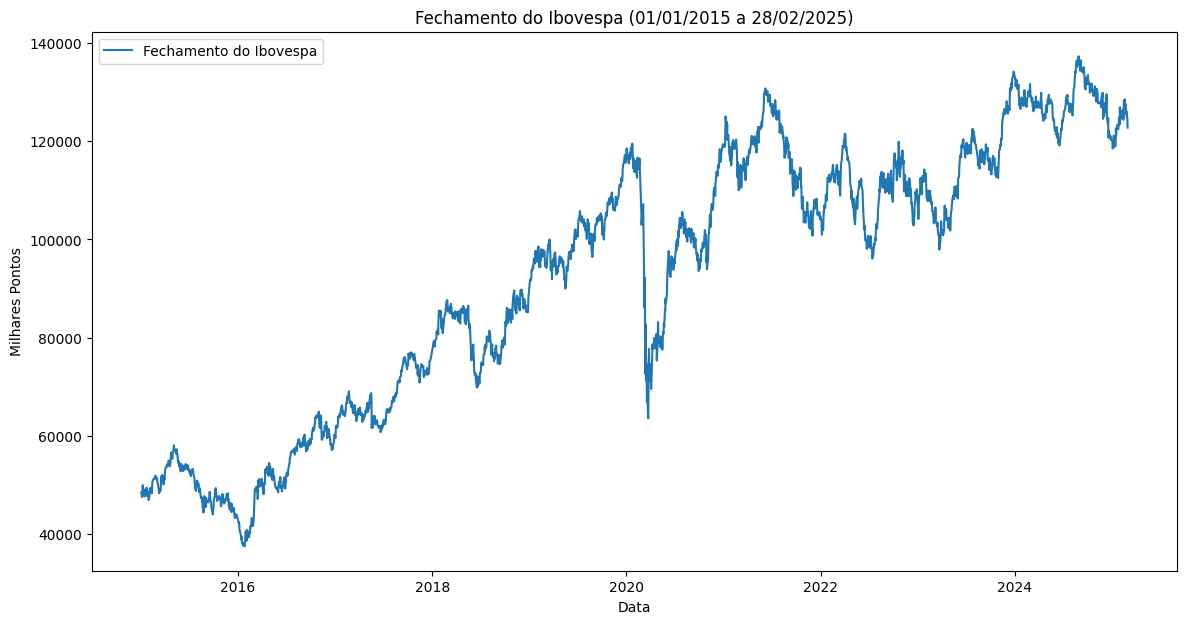

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(bovespa_fechamentos.index, bovespa_fechamentos.values, label="Fechamento do Ibovespa")
plt.title("Fechamento do Ibovespa (01/01/2015 a 28/02/2025)")
plt.xlabel("Data")
plt.ylabel("Milhares Pontos")
plt.legend()
plt.show()

In [ ]:
#Percebemos que os nossos dados tem uma tendência de crescimento ao longo do tempo e que foram afetados no periodo do covid 19, principalmente no primeiro ano da pandemia(2020).

In [ ]:
#Para começar a entender o comportamento da série, vamos fazer a decomposição, como os dados são diários, analisaremos o comportamento anual (period=365).
decomposicao = seasonal_decompose(bovespa_fechamentos,period=365)

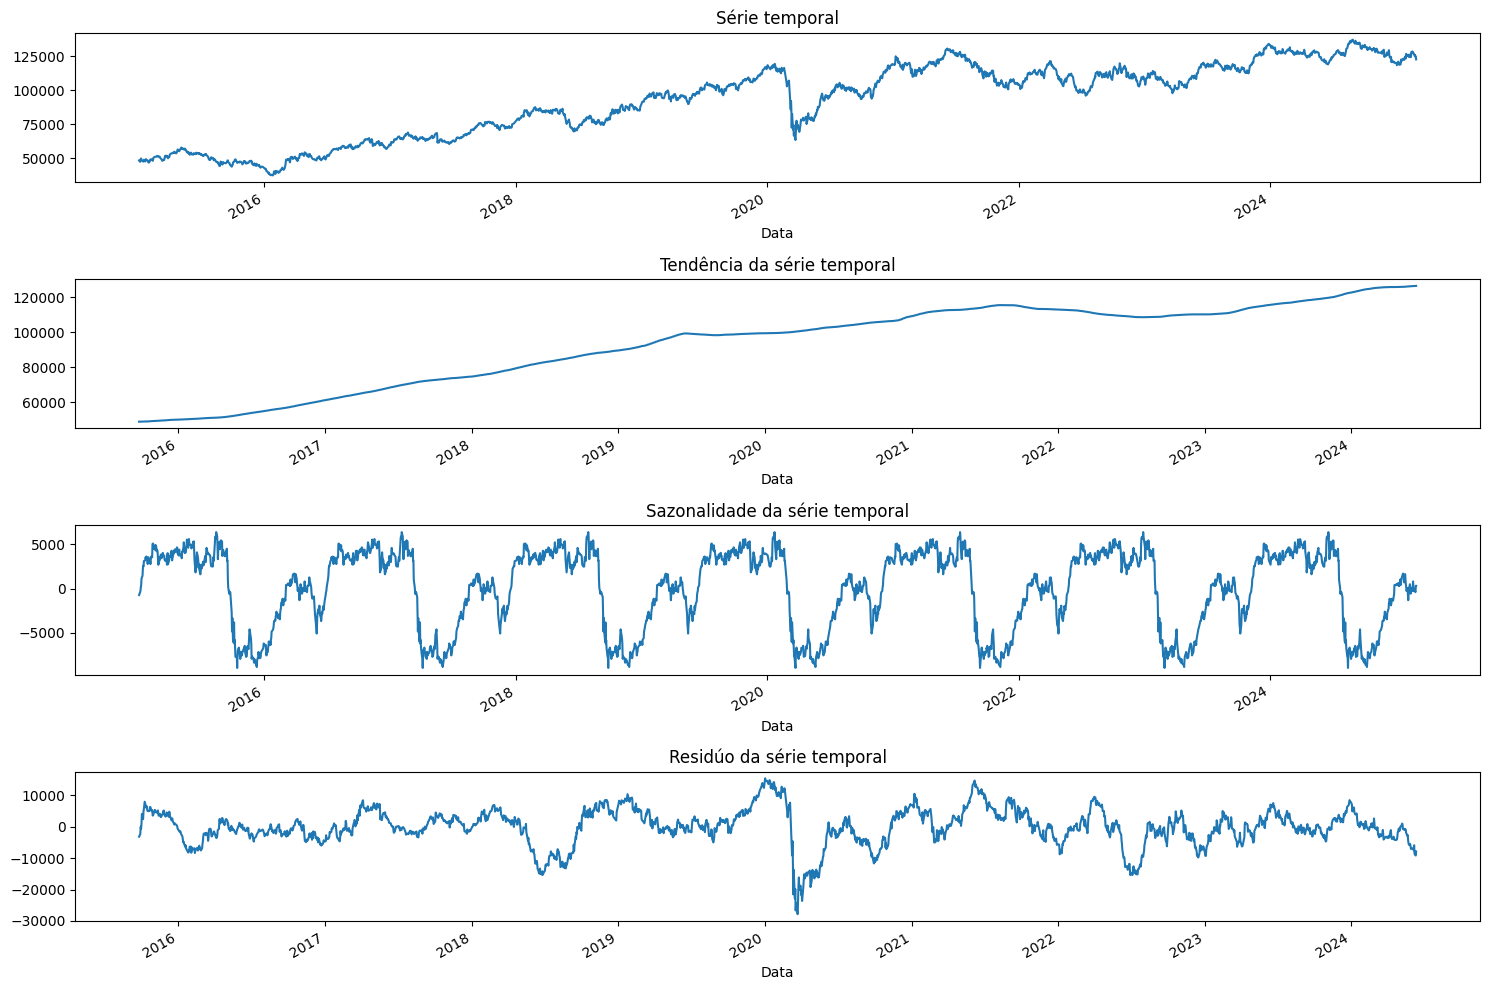

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,10))

decomposicao.observed.plot(ax=ax1) # plotando a série com dados brutos
ax1.set_title('Série temporal')
decomposicao.trend.plot(ax=ax2) # plotando a tendência da série
ax2.set_title('Tendência da série temporal')
decomposicao.seasonal.plot(ax=ax3) # plotando a sazonalidade da série
ax3.set_title('Sazonalidade da série temporal')
decomposicao.resid.plot(ax=ax4) # plotando o resúduo da série
ax4.set_title('Residúo da série temporal')


plt.tight_layout()

In [ ]:
# Apesar da nossa série temporal ter uma tendência de crescimento, o que já indica que ela não é uma série estacionária, vamos fazer o teste do ADF (Dickey-Fuller Aumentado)

# Vamos salvar os valores da série em um array (x)
x=bovespa_fechamentos.values

resultado_adf=adfuller(x)
print('Teste ADF')
print(f"Teste Estatistico: {resultado_adf[0]}")
print(f"P-Value: {resultado_adf[1]}")
print("Valores criticos: ")

for key, value in resultado_adf[4].items():
  print(f"\t{key}:{value}")

# Como o teste resultou em um valor maior do que os valores críticos, temos a confirmação de que ela não é estacionária

Teste ADF
Teste Estatistico: -1.113530955311309
P-Value: 0.7096458629661705
Valores criticos: 
	1%:-3.432955889694659
	5%:-2.8626912706428715
	10%:-2.567382865538409


<Axes: xlabel='Data'>

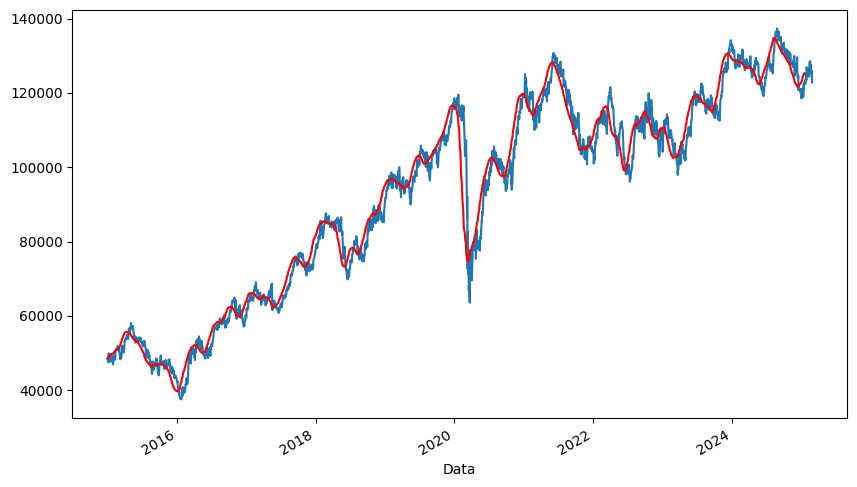

In [ ]:
# Verificando o comportamento da média móvel durante o passar do tempo
ma = bovespa_fechamentos.rolling(30).mean()

f, ax = plt.subplots(figsize=(10,6))
bovespa_fechamentos.plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='r')


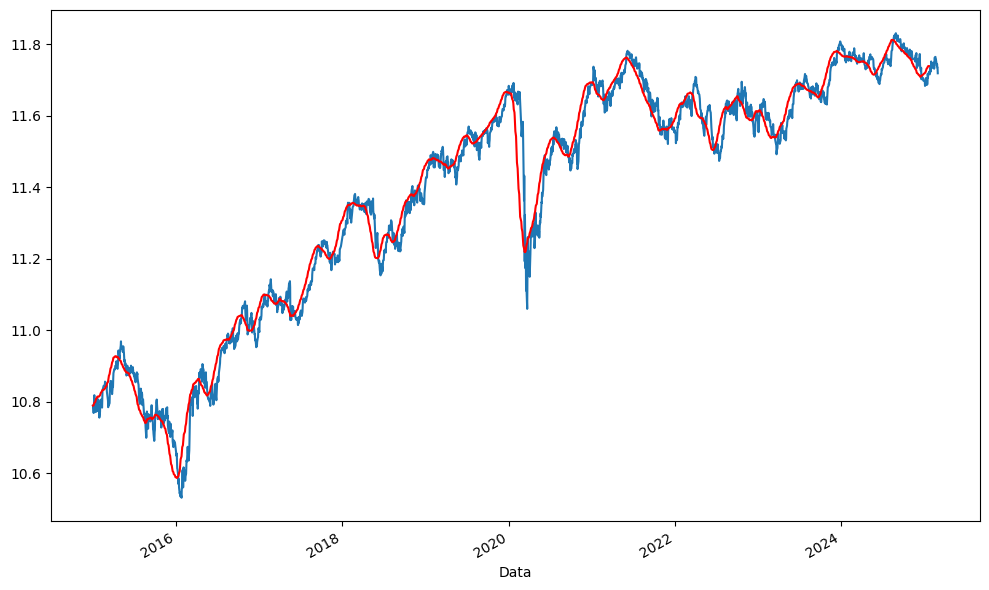

In [ ]:
# Como podemos observar, temos um comportamento muito fora do padrão na epoca da pandemia.

# Para verificar se a série pode ser tranformada em estacionária, e assim suavizar o comportamento durante a pandemia, vamos aplicar a transformação logaritmica.
bovespa_fechamentos_log = np.log(bovespa_fechamentos)
ma_log = bovespa_fechamentos_log.rolling(30).mean()

f, ax = plt.subplots(figsize=(10,6))
bovespa_fechamentos_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

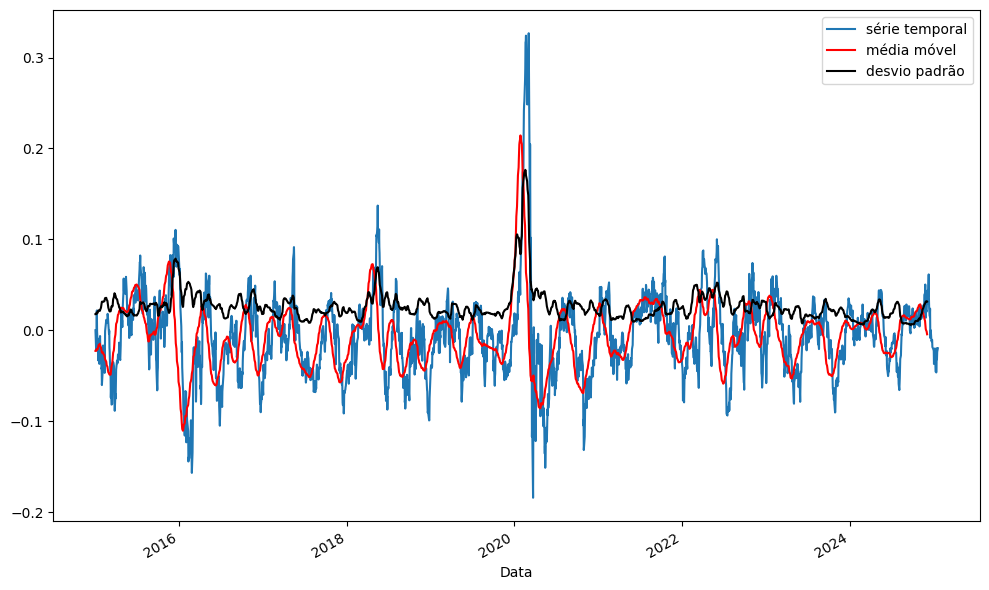

In [ ]:
# Seguindo com a suavização vamos retirar o efeito da média móvel da série
bovespa_fechamentos_s = (bovespa_fechamentos_log - ma_log).dropna()

ma_s = bovespa_fechamentos_s.rolling(30).mean()

std = bovespa_fechamentos_s.rolling(30).std()

f, ax = plt.subplots(figsize=(10,6))
bovespa_fechamentos_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='black')
plt.legend(['série temporal','média móvel','desvio padrão'])
plt.tight_layout()


<Axes: xlabel='Data'>

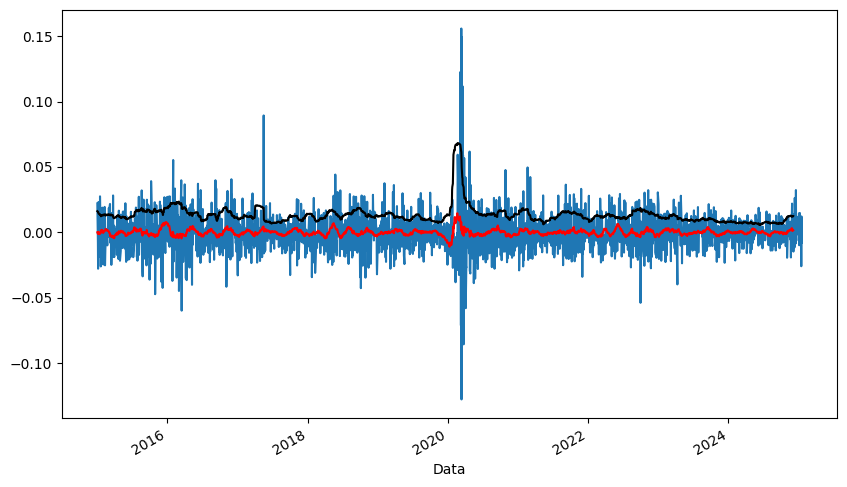

In [ ]:
# Para finalizar, vamos aplicar a diferenciação
bovespa_fechamentos_diff = bovespa_fechamentos_s.diff(1)
ma_diff = bovespa_fechamentos_diff.rolling(30).mean()

std_diff = bovespa_fechamentos_diff.rolling(30).std()

f, ax = plt.subplots(figsize=(10,6))
bovespa_fechamentos_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='black')

# Mesmo aplicando a diferenciação na série, não conseguimos equalizar os efeitos no desvio padrão na epoca da pandemia.


In [ ]:
# Vamos aplicar novamente o teste de ADF, para verificar se agora a série é estacionária
x=bovespa_fechamentos_diff.dropna()

resultado_adf=adfuller(x)
print('Teste ADF')
print(f"Teste Estatistico: {resultado_adf[0]}")
print(f"P-Value: {resultado_adf[1]}")
print("Valores criticos: ")

for key, value in resultado_adf[4].items():
  print(f"\t{key}:{value}")

# Como o resultado do teste estatistico é menor que os valores críticos, a série passou a ser estacionária.

Teste ADF
Teste Estatistico: -13.044278596341325
P-Value: 2.208296111878844e-24
Valores criticos: 
	1%:-3.4330045498933544
	5%:-2.8627127589354426
	10%:-2.567394306200992


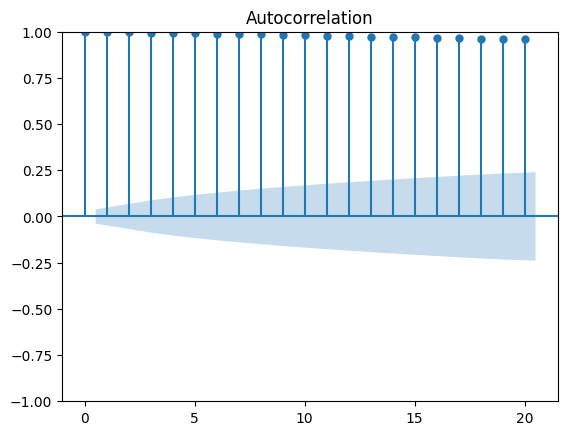

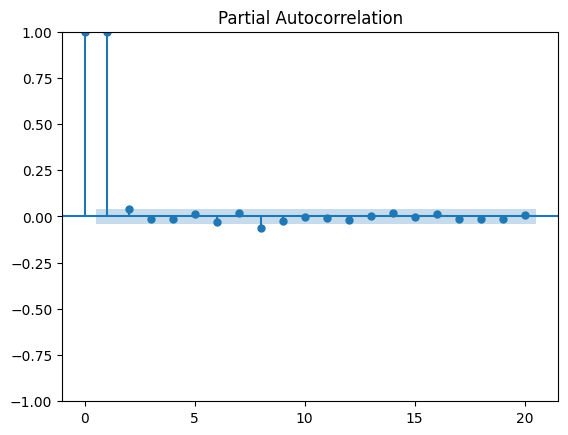

In [ ]:
# Antes de começarmos a desenvolver os modelos, vamos verificar a correlação da série temporal
plot_acf(bovespa_fechamentos.dropna(), lags=20)
plot_pacf(bovespa_fechamentos.dropna(), lags=20)
plt.show()



# Desenvolvimento de modelos #

## Separação das bases de treino e teste ##


In [ ]:
# Renomeamos o nome das colunas para ds (data) e y (fechamento), para padronizar e facilitar a aplicação nos modelos.
# Resetamos o índice do dataframe para transformar o índice na coluna 'ds'
bovespa_fechamentos_modelo=bovespa_fechamentos
bovespa_fechamentos_modelo.rename(columns={'Fechamento':'y'}, inplace=True)
bovespa_fechamentos_modelo.rename_axis(index={'Data':'ds'},inplace=True)
bovespa_fechamentos_modelo['unique_id']='Ibovespa'
bovespa_fechamentos_modelo.reset_index(inplace=True)

In [ ]:
# Devido a nossa base de dados ter uma queda significativa no primeiro ano da pandemia (2020),
# optamos por usar os dados a partir de 01/01/2021, sendo assim nossa base contemplará 4 anos de histórico
bovespa_fechamentos_modelo=bovespa_fechamentos_modelo[bovespa_fechamentos_modelo['ds']>='2021-01-01']

In [ ]:
# Vamos criar o dataframe de validação e treino
# A validação iremos usar os últimos 30 dias do dataframe original, como nossa base tem dados até 28/02/2025 a base de validação iniciará dia 20/01/2025
# O treino usaremos os demais períodos
validacao = bovespa_fechamentos_modelo[(bovespa_fechamentos_modelo['ds']>='2025-01-20')]
treino = bovespa_fechamentos_modelo[(bovespa_fechamentos_modelo['ds']<'2025-01-20')] #& (bovespa_fechamentos['ds']>'2024-01-01')]
h=validacao['ds'].nunique()

In [ ]:
# Tamanho da base de validação (possui dias uteis)
h

30

In [ ]:
# Vamos criar um novo parametro h2 para incluir os feriados (6) que não estão na base de validação.
# Esse novo h2 vai ser usado para os modelos.
h2=h

In [ ]:
# Criando a função para medir a acuracia do modelo com wmape
def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum()/np.abs(y_true).sum()

## Naive ##

WMAPE: 2.36%
MAPE: 2.35%
MAE: 2963.333251953125
MSE: 11907193.0


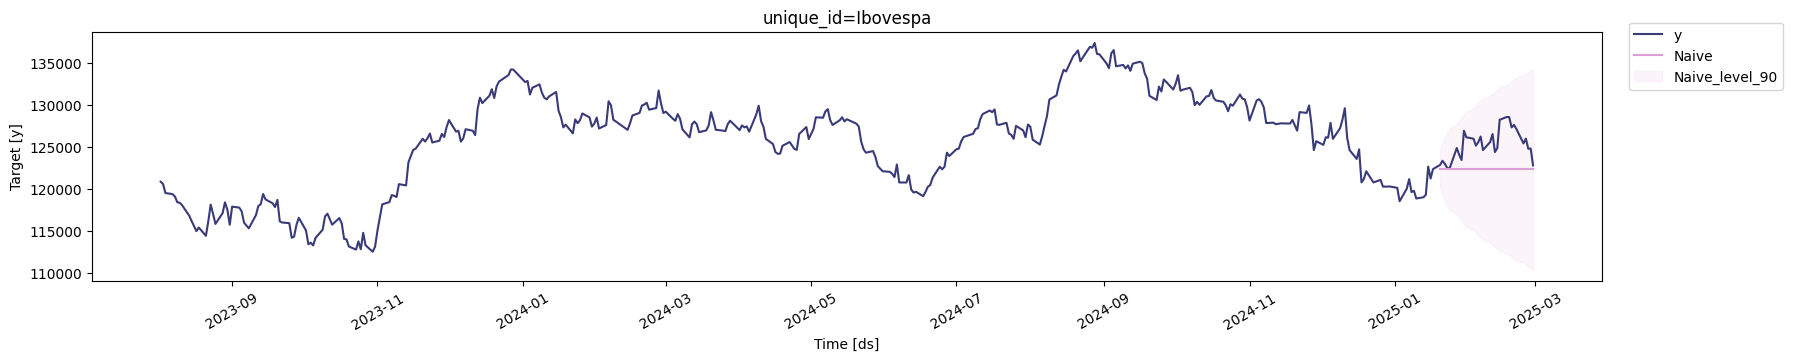

In [ ]:
# Como nosso dataframe original só possui dias uteis, vamos usar a frequencia para dias uteis em nossa previsão (freq='B')
# Usaremos também todos os núcleos de processamento (n_jobs=-1)
model_naive = StatsForecast(models=[Naive()], freq='B', n_jobs=-1)
model_naive.fit(treino)


forecast_naive= model_naive.predict(h=h2, level=[90])
forecast_naive = forecast_naive.merge(validacao, on=['ds','unique_id'], how='inner')


wmape_naive = wmape(forecast_naive['y'].values, forecast_naive['Naive'].values)
mae_naive = mean_absolute_error(forecast_naive['y'].values, forecast_naive['Naive'].values)
mape_naive = mean_absolute_percentage_error(forecast_naive['y'].values, forecast_naive['Naive'].values)
mse_naive = mean_squared_error(forecast_naive['y'].values, forecast_naive['Naive'].values)

print(f"WMAPE: {wmape_naive:.2%}")
print(f"MAPE: {mape_naive:.2%}")
print(f"MAE: {mae_naive}")
print(f"MSE: {mse_naive}")
model_naive.plot(treino, forecast_naive, level=[90], unique_ids=['Ibovespa'],engine ='matplotlib', max_insample_length=365)

Como o Naive é um modelo baseline que se baseia apenas no valor do último periodo, o resultado é constante e pouco útil como previsão

## Seasonal Naive ##

WMAPE: 3.95%
MAPE: 3.93%
MAE: 4948.7001953125
MSE: 29584920.0


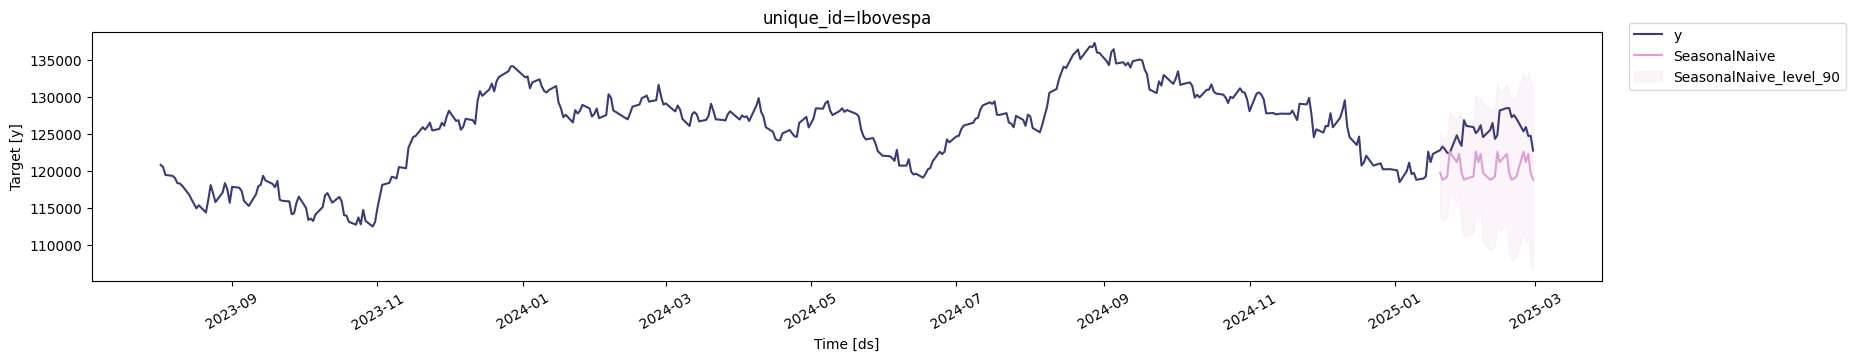

In [ ]:
# Como nosso dataframe original só possui dias uteis, vamos usar a frequencia para dias uteis em nossa previsão (freq='B')
# Usaremos também todos os núcleos de processamento (n_jobs=-1)
# Consideramos sazonalidade semanal (season_length=7)
model_seasonalnaive = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='B', n_jobs=-1)
model_seasonalnaive.fit(treino)

forecast_seasonalnaive= model_seasonalnaive.predict(h=h2, level=[90])
forecast_seasonalnaive = forecast_seasonalnaive.merge(validacao, on=['ds','unique_id'], how='inner')



wmape_seasonalnaive = wmape(forecast_seasonalnaive['y'].values, forecast_seasonalnaive['SeasonalNaive'].values)
mae_seasonalnaive = mean_absolute_error(forecast_seasonalnaive['y'].values, forecast_seasonalnaive['SeasonalNaive'].values)
mape_seasonalnaive = mean_absolute_percentage_error(forecast_seasonalnaive['y'].values, forecast_seasonalnaive['SeasonalNaive'].values)
mse_seasonalnaive = mean_squared_error(forecast_seasonalnaive['y'].values, forecast_seasonalnaive['SeasonalNaive'].values)

print(f"WMAPE: {wmape_seasonalnaive:.2%}")
print(f"MAPE: {mape_seasonalnaive:.2%}")
print(f"MAE: {mae_seasonalnaive}")
print(f"MSE: {mse_seasonalnaive}")


model_seasonalnaive.plot(treino, forecast_seasonalnaive, level=[90], unique_ids=['Ibovespa'],engine ='matplotlib', max_insample_length=365)

O modelo Seasonal Naive já inclui em sua previsão a sazonalidade dos dados, porém percebemos que ainda não foi muito eficiente em se enquadrar ao comportamento dos nossos dados.

## AUTO ARIMA ##

WMAPE: 2.36%
MAPE: 2.35%
MAE: 2963.333251953125
MSE: 11907193.0


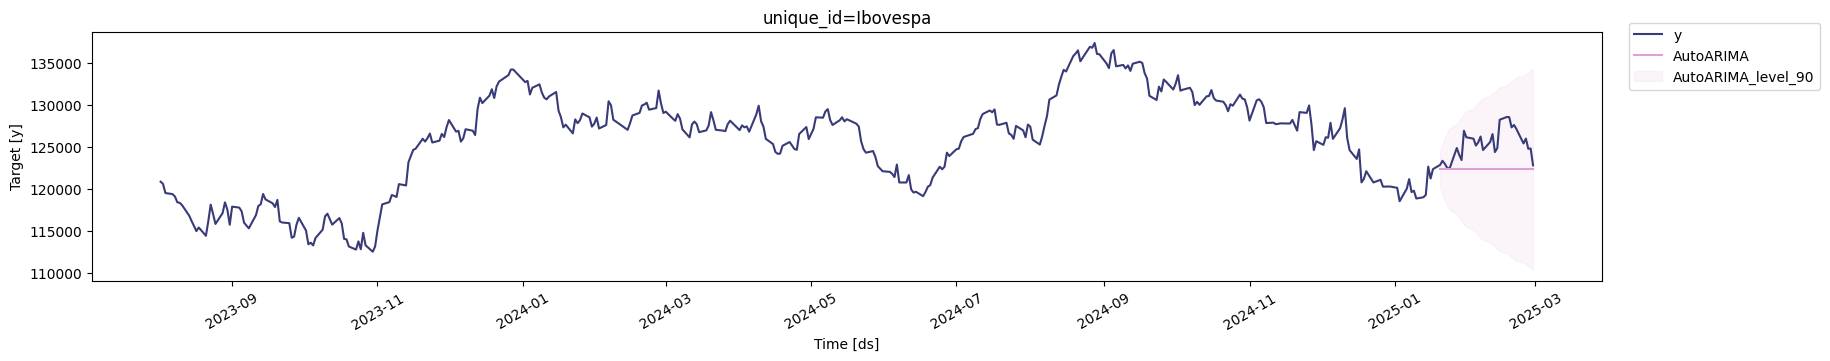

In [ ]:
# Como nosso dataframe original só possui dias uteis, vamos usar a frequencia para dias uteis em nossa previsão (freq='B')
# Usaremos também todos os núcleos de processamento (n_jobs=-1)
# Consideramos sazonalidade semanal (season_length=7)

model_arima = StatsForecast(models=[AutoARIMA(season_length=7)], freq='B', n_jobs=-1)
model_arima.fit(treino)

forecast_arima= model_arima.predict(h=h2, level=[90])
forecast_arima = forecast_arima.merge(validacao, on=['ds','unique_id'], how='inner')


wmape_arima = wmape(forecast_arima['y'].values, forecast_arima['AutoARIMA'].values)
mae_arima = mean_absolute_error(forecast_arima['y'].values, forecast_arima['AutoARIMA'].values)
mape_arima = mean_absolute_percentage_error(forecast_arima['y'].values, forecast_arima['AutoARIMA'].values)
mse_arima = mean_squared_error(forecast_arima['y'].values, forecast_arima['AutoARIMA'].values)

print(f"WMAPE: {wmape_arima:.2%}")
print(f"MAPE: {mape_arima:.2%}")
print(f"MAE: {mae_arima}")
print(f"MSE: {mse_arima}")


model_arima.plot(treino, forecast_arima, level=[90], unique_ids=['Ibovespa'],engine ='matplotlib', max_insample_length=365)

o modelo ARIMA, que apesar de ser mais sofisticado que os modelos NAIVE, não conseguiu prever a sazonlidade de forma satisfatória.

## Prophet ##

In [ ]:

class B3Holidays(AbstractHolidayCalendar):
   rules = [
        Holiday("Confraternização Universal", month=1, day=1),
        #Holiday("Carnaval", month=2, day=28),  # Ajuste conforme o ano
        Holiday("Sexta-feira Santa", month=4, day=7),
        Holiday("Tiradentes", month=4, day=21),
        Holiday("Dia do Trabalho", month=5, day=1),
        Holiday("Independência", month=9, day=7),
        Holiday("Nossa Senhora Aparecida", month=10, day=12),
        Holiday("Finados", month=11, day=2),
        Holiday("Proclamação da República", month=11, day=15),
        Holiday("Natal", month=12, day=25),
    ]

b3_holidays = B3Holidays().holidays(start='2015-01-01', end='2025-12-31')

In [ ]:
#Criando um DataFrame com as datas e um indicador para o período da COVID
covid_dates = pd.date_range(start='2020-03-01', end='2021-06-30', freq='B')  # Período crítico da pandemia
covid_df = pd.DataFrame({'ds': covid_dates, 'covid_impact': 1})

In [ ]:
# Vamos estanciar o modelo na variavel model_prophet
#model_prophet = Prophet(weekly_seasonality=True,daily_seasonality=True,yearly_seasonality=True, seasonality_mode='multiplicative')

model_prophet = Prophet(weekly_seasonality=True, daily_seasonality=False,yearly_seasonality=True,holidays=pd.DataFrame({'ds': b3_holidays, 'holiday': 'feriado'}),seasonality_mode='multiplicative')

#tratando sazonalidade
model_prophet.add_seasonality(name='daily', period=1, fourier_order=10)

#tratando COVID
model_prophet.add_regressor('covid_impact')
model_prophet.add_country_holidays(country_name='BR')

#Juntando os dados de treino com o impacto da COVID
treino = treino.merge(covid_df, on='ds', how='left').fillna(0)

# Fazendo o treinamento do modelo
model_prophet.fit(treino)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxuonf67k/i2ql1pbq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxuonf67k/fpody3f6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27777', 'data', 'file=/tmp/tmpxuonf67k/i2ql1pbq.json', 'init=/tmp/tmpxuonf67k/fpody3f6.json', 'output', 'file=/tmp/tmpxuonf67k/prophet_model3l_gwg8z/prophet_model-20250310133026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:30:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:30:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Gerando as datas que serão usadas na previsão do modelo
future = model_prophet.make_future_dataframe(periods=h2,freq='B')

# Adicionando a coluna 'covid_impact' ao conjunto de previsão
future = future.merge(covid_df, on='ds', how='left').fillna(0)

# Gerando as previsões
forecast_prophet = model_prophet.predict(future)


#forecast_prophet = forecast_prophet.merge(bovespa_fechamentos_modelo, on=['ds'], how='inner')


WMAPE: 1.75%
MAPE: 1.73%
MAE: 2090.4897000000014
MSE: 7883131.484270308


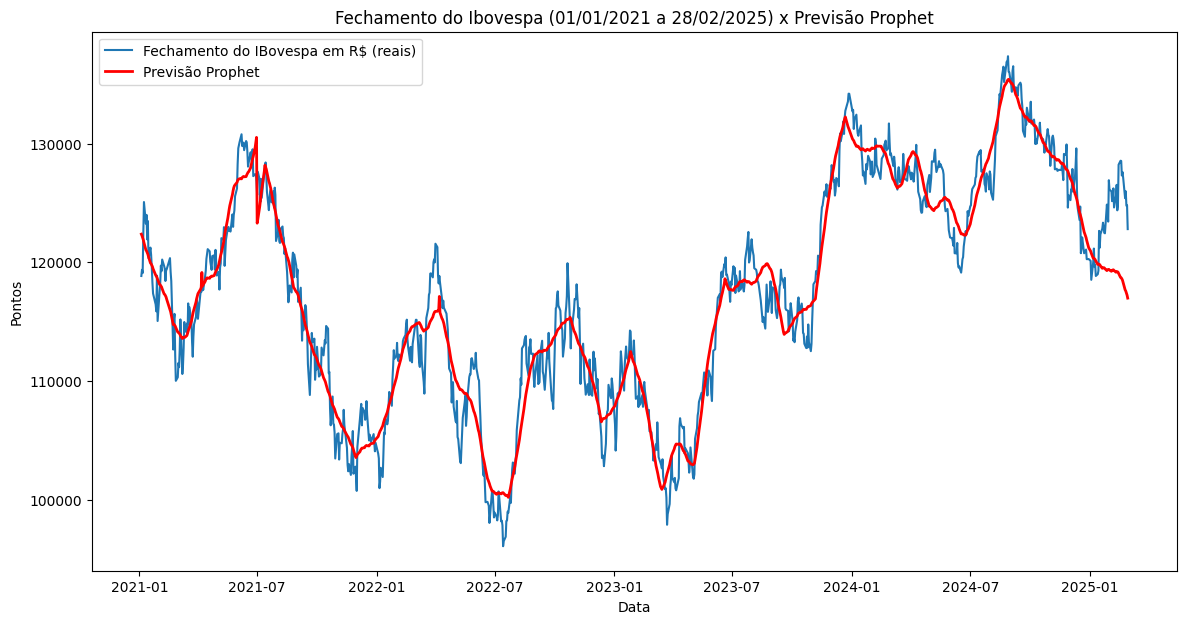

In [ ]:
# Plotando o resultado do modelo prophet x dados originais
# Calculando o wmape apenas dos ultimos 90 dias como foi feito nos modelos anteriores


wmape_prophet = wmape(bovespa_fechamentos_modelo['y'].tail(30).values, forecast_prophet['yhat'].tail(30).values.round(3))
mae_prophet = mean_absolute_error(bovespa_fechamentos_modelo['y'].tail(30).values, forecast_prophet['yhat'].tail(30).values.round(3))
mape_prophet = mean_absolute_percentage_error(bovespa_fechamentos_modelo['y'].tail(30).values, forecast_prophet['yhat'].tail(30).values.round(3))
mse_prophet = mean_squared_error(bovespa_fechamentos_modelo['y'].tail(30).values, forecast_prophet['yhat'].tail(30).values.round(3))




print(f"WMAPE: {wmape_prophet:.2%}")
print(f"MAPE: {mape_prophet:.2%}")
print(f"MAE: {mae_prophet}")
print(f"MSE: {mse_prophet}")



plt.figure(figsize=(14, 7))
plt.plot(bovespa_fechamentos_modelo['ds'], bovespa_fechamentos_modelo['y'], label="Fechamento do IBovespa em R$ (reais)")
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label="Previsão Prophet", color='r', linewidth=2)
plt.title("Fechamento do Ibovespa (01/01/2021 a 28/02/2025) x Previsão Prophet")
plt.xlabel("Data")
plt.ylabel("Pontos")
plt.legend()
plt.show()

O Prophet foi o modelo que nos trouxe o melhor resultado, foi mais eficiente em prever sazonalidade.

In [ ]:
parametros_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1.0],  # Trend flexibility
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],  # Seasonal effect strength
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],  # Holiday effect flexibility
    'seasonality_mode': ['additive', 'multiplicative'],  # Additive vs. Multiplicative seasonality
    'weekly_seasonality':['True','False'],
    'daily_seasonality':['True','False'],
    'yearly_seasonality':['True','False']
}


In [ ]:
combinacao_parametros = list(product(*parametros_grid.values()))

In [ ]:
melhor_mape_prophet=100

In [ ]:
for parametro in combinacao_parametros:
  # Create model with given parameters
  model_prophet_grid = Prophet(
  changepoint_prior_scale=parametro[0],
  seasonality_prior_scale=parametro[1],
  holidays_prior_scale=parametro[2],
  seasonality_mode=parametro[3],
  weekly_seasonality=parametro[4],
  daily_seasonality=parametro[5],
  yearly_seasonality=parametro[6],
  holidays=pd.DataFrame({'ds': b3_holidays, 'holiday': 'feriado'}))

  #tratando sazonalidade
  model_prophet_grid.add_seasonality(name='daily', period=1, fourier_order=10)

  #tratando COVID
  model_prophet_grid.add_regressor('covid_impact')
  model_prophet_grid.add_country_holidays(country_name='BR')

  #Juntando os dados de treino com o impacto da COVID
  #treino = treino.merge(covid_df, on='ds', how='left').fillna(0)

  model_prophet_grid=model_prophet_grid.fit(treino)

  # Gerando as datas que serão usadas na previsão do modelo
  future = model_prophet_grid.make_future_dataframe(periods=h2,freq='B')
  # Adicionando a coluna 'covid_impact' ao conjunto de previsão
  future = future.merge(covid_df, on='ds', how='left').fillna(0)
  # Gerando as previsões
  forecast_prophet = model_prophet_grid.predict(future)
  mape_prophet = mean_absolute_percentage_error(bovespa_fechamentos_modelo['y'].tail(30).values, forecast_prophet['yhat'].tail(30).values.round(3))
  if mape_prophet < melhor_mape_prophet:
    melhor_mape_prophet = mape_prophet
    melhores_parametros = parametro


ValueError: invalid literal for int() with base 10: 'True'

In [ ]:
melhores_parametros

In [ ]:
melhor_mape_prophet

In [ ]:
model_prophet = Prophet(weekly_seasonality=True,
                        daily_seasonality=True,
                        yearly_seasonality=True,
                        holidays=pd.DataFrame({'ds': b3_holidays, 'holiday': 'feriado'}),
                        changepoint_prior_scale=melhores_parametros[0],
                        seasonality_prior_scale=melhores_parametros[1],
                        holidays_prior_scale=melhores_parametros[2],
                        seasonality_mode=melhores_parametros[3])

In [ ]:
model_prophet.fit(treino)

In [ ]:
# Gerando as datas que serão usadas na previsão do modelo
future = model_prophet.make_future_dataframe(periods=h2,freq='B')

# Adicionando a coluna 'covid_impact' ao conjunto de previsão
future = future.merge(covid_df, on='ds', how='left').fillna(0)

# Gerando as previsões
forecast_prophet = model_prophet.predict(future)


In [ ]:
# Plotando o resultado do modelo prophet x dados originais
# Calculando o wmape apenas dos ultimos 90 dias como foi feito nos modelos anteriores


wmape_prophet = wmape(bovespa_fechamentos_modelo['y'].tail(30).values, forecast_prophet['yhat'].tail(30).values.round(3))
mae_prophet = mean_absolute_error(bovespa_fechamentos_modelo['y'].tail(30).values, forecast_prophet['yhat'].tail(30).values.round(3))
mape_prophet = mean_absolute_percentage_error(bovespa_fechamentos_modelo['y'].tail(30).values, forecast_prophet['yhat'].tail(30).values.round(3))
mse_prophet = mean_squared_error(bovespa_fechamentos_modelo['y'].tail(30).values, forecast_prophet['yhat'].tail(30).values.round(3))




print(f"WMAPE: {wmape_prophet:.2%}")
print(f"MAPE: {mape_prophet:.2%}")
print(f"MAE: {mae_prophet}")
print(f"MSE: {mse_prophet}")



plt.figure(figsize=(14, 7))
plt.plot(bovespa_fechamentos_modelo['ds'], bovespa_fechamentos_modelo['y'], label="Fechamento do IBovespa em R$ (reais)")
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label="Previsão Prophet", color='r', linewidth=2)
plt.title("Fechamento do Ibovespa (01/01/2021 a 28/02/2025) x Previsão Prophet")
plt.xlabel("Data")
plt.ylabel("Pontos")
plt.legend()
plt.show()

# Sarima

WMAPE: 2.50%
MAPE: 2.48%
MAE: 3120.290283203125
MSE: 12857118.0


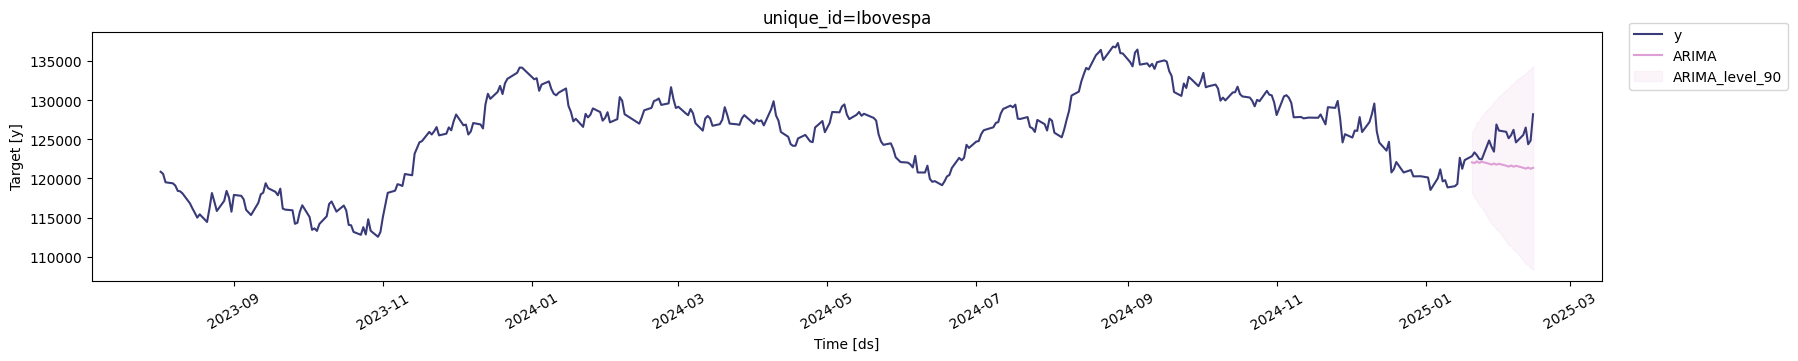

In [ ]:
treino = treino.drop(columns=['covid_impact'])



model_sarima = StatsForecast(
    models=[ARIMA(
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1),
        season_length=7              # Sazonalidade semanal
    )],
    freq='D',
    n_jobs=-1
)

model_sarima.fit(treino)
forecast_sarima = model_sarima.predict(h=h2, level=[90])
forecast_sarima = forecast_sarima.merge(validacao, on=['ds', 'unique_id'], how='inner')

wmape_sarima = wmape(forecast_sarima['y'], forecast_sarima['ARIMA'])
mae_sarima = mean_absolute_error(forecast_sarima['y'], forecast_sarima['ARIMA'])
mape_sarima = mean_absolute_percentage_error(forecast_sarima['y'], forecast_sarima['ARIMA'])
mse_sarima = mean_squared_error(forecast_sarima['y'], forecast_sarima['ARIMA'])

print(f"WMAPE: {wmape_sarima:.2%}")
print(f"MAPE: {mape_sarima:.2%}")
print(f"MAE: {mae_sarima}")
print(f"MSE: {mse_sarima}")


model_sarima.plot(treino, forecast_sarima, level=[90], unique_ids=['Ibovespa'], engine='matplotlib', max_insample_length=365)